In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, ensemble, tree, linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import xgboost as xgb

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
%matplotlib inline
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 22, 4
import warnings
import time

warnings.filterwarnings('ignore')

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_y = train_df.pop('SalePrice') # take out y value
test_id = test_df.pop('Id') # for writing submission file
# also remove id column from train as it will not be used
train_df.drop('Id', axis = 1, inplace=True)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
print train_df.shape
print test_df.shape

(1460, 79)
(1459, 79)


In [4]:
# check number of nan in both train and test for each columns
def check_null(df):
    null_check = df.isnull().sum(axis=0)
    null = null_check[null_check!=0]
    null_df = df.isnull()
    return null, null_df
train_null, _ = check_null(train_df)
test_null, _ = check_null(test_df)
# print ">>>null value in train:\n", train_null
# print "\n>>>null value in test:\n", test_null

In [5]:
# get rid off columns with missing values more than half
drop_cols1 = [train_null.index[i] for i in range(train_null.shape[0]) if train_null.values[i] > train_df.shape[0]/2]
drop_cols2 = [test_null.index[i] for i in range(test_null.shape[0]) if test_null.values[i] > test_df.shape[0]/2]
drop_cols = list(set(drop_cols1+drop_cols2))
print drop_cols

['PoolQC', 'MiscFeature', 'FireplaceQu', 'Fence', 'Alley']


In [6]:
# finish drop and start impute rest missing data
train_df.drop(drop_cols, axis = 1, inplace=True)
test_df.drop(drop_cols, axis = 1, inplace=True)

# after dropping selected columns, we want to impute which requires
# data to be numeric value, so we proceed to convert categorical data
# but this conversion erases nan, so here we record where the nan is
_, train_nulls = check_null(train_df)
_, test_nulls = check_null(test_df)

In [7]:
# convert object to categorical value first
obj_columns = train_df.select_dtypes(['object']).columns
num_columns = list(set(train_df.columns)-set(obj_columns))
for col in obj_columns:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    # same conversion should be applied to test data also
    map_col = dict(zip(list(train_df[col].unique()), list(train_df[col].cat.codes.unique())))
    # convert test_df categorical column
    test_df[col] = test_df[col].apply(lambda x: map_col[x]).astype('int')
#     print "Done", col

# now convert train set
train_df[obj_columns] = train_df[obj_columns].apply(lambda x: x.cat.codes)

In [8]:
# get the nan back
train_df[train_nulls] = np.nan
test_df[test_nulls] = np.nan

In [9]:
# impute missing data

# train_filled = SimpleFill().complete(train_df)
train_filled = SoftImpute().complete(train_df)
# train_filled = KNN(k=5).complete(train_df)
# train_filled = MICE().complete(train_df)

test_filled = SoftImpute().complete(test_df)
# test_filled = KNN(k=5).complete(test_df)

train_filled = pd.DataFrame(train_filled, columns=train_df.columns)
test_filled = pd.DataFrame(test_filled, columns=test_df.columns)

[SoftImpute] Max Singular Value of X_init = 569792.695239
[SoftImpute] Iter 1: observed MAE=33.836817 rank=7
[SoftImpute] Iter 2: observed MAE=33.644316 rank=6
[SoftImpute] Iter 3: observed MAE=33.305490 rank=6
[SoftImpute] Iter 4: observed MAE=33.232761 rank=6
[SoftImpute] Iter 5: observed MAE=33.215412 rank=6
[SoftImpute] Iter 6: observed MAE=33.211095 rank=6
[SoftImpute] Iter 7: observed MAE=33.209985 rank=6
[SoftImpute] Stopped after iteration 7 for lambda=11395.853905
[SoftImpute] Max Singular Value of X_init = 449876.391390
[SoftImpute] Iter 1: observed MAE=29.721956 rank=8
[SoftImpute] Iter 2: observed MAE=29.755301 rank=8
[SoftImpute] Iter 3: observed MAE=29.438489 rank=7
[SoftImpute] Iter 4: observed MAE=29.319541 rank=7
[SoftImpute] Iter 5: observed MAE=29.291801 rank=7
[SoftImpute] Iter 6: observed MAE=29.284988 rank=7
[SoftImpute] Iter 7: observed MAE=29.283290 rank=7
[SoftImpute] Stopped after iteration 7 for lambda=8997.527828


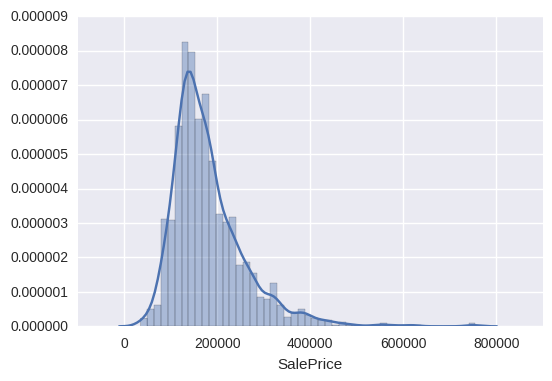

In [10]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_y)

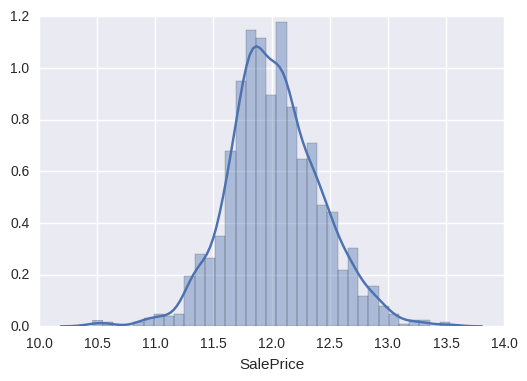

In [11]:
## we can log transform y value
ax = sns.distplot(np.log(train_y))
train_y = np.log(train_y)

In [12]:
# fisrt option: standarize non-categoorical values
std_features = list(set(train_filled.columns)-set(obj_columns))
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
train_filled[std_features] = ss.fit_transform(train_filled[std_features])
test_filled[std_features] = ss.transform(test_filled[std_features])

# second option: standarize all values
# ss = StandardScaler(copy=True, with_mean=True, with_std=True)
# train_filled[train_filled.columns] = ss.fit_transform(train_filled)
# test_filled[test_filled.columns] = ss.transform(test_filled)

In [13]:
train_filled[num_columns].describe()

,3SsnPorch,BsmtFullBath,OpenPorchSF,2ndFlrSF,HalfBath,OverallCond,LotArea,GrLivArea,YearRemodAdd,MasVnrArea,...,MSSubClass,YearBuilt,BsmtFinSF1,BsmtFinSF2,PoolArea,ScreenPorch,BedroomAbvGr,LowQualFinSF,GarageArea,GarageCars
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,...,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-2.433366e-17,-7.300097e-18,5.231736e-17,8.516779e-18,-5.779243e-18,3.345878e-16,-6.570087e-17,-1.411352e-16,4.462792e-15,2.920039e-17,...,-4.258390e-17,1.053647e-15,-2.433366e-17,2.250863e-17,-4.866731e-18,3.041707e-17,2.725369e-16,-2.676702e-17,-1.825024e-17,1.216683e-16
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,...,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-1.163393e-01,-8.199644e-01,-7.044833e-01,-7.951632e-01,-7.616207e-01,-4.112970e+00,-9.237292e-01,-2.249120e+00,-1.689368e+00,-5.752392e-01,...,-8.725628e-01,-3.287824e+00,-9.730182e-01,-2.886528e-01,-6.869175e-02,-2.702084e-01,-3.514952e+00,-1.202417e-01,-2.212963e+00,-2.365440e+00
25%,-1.163393e-01,-8.199644e-01,-7.044833e-01,-7.951632e-01,-7.616207e-01,-5.171998e-01,-2.969908e-01,-7.347485e-01,-8.656586e-01,-5.752392e-01,...,-8.725628e-01,-5.719226e-01,-9.730182e-01,-2.886528e-01,-6.869175e-02,-2.702084e-01,-1.062465e+00,-1.202417e-01,-6.479160e-01,-1.026858e+00
50%,-1.163393e-01,-8.199644e-01,-3.270298e-01,-7.951632e-01,-7.616207e-01,-5.171998e-01,-1.040633e-01,-9.797004e-02,4.425864e-01,-5.752392e-01,...,-1.631095e-01,5.737148e-02,-1.319022e-01,-2.886528e-01,-6.869175e-02,-2.702084e-01,1.637791e-01,-1.202417e-01,3.284429e-02,3.117246e-01
75%,-1.163393e-01,1.107810e+00,3.221901e-01,8.731117e-01,1.227585e+00,3.817427e-01,1.087080e-01,4.974036e-01,9.271216e-01,3.441058e-01,...,3.098594e-01,9.516316e-01,5.891327e-01,-2.886528e-01,-6.869175e-02,-2.702084e-01,1.637791e-01,-1.202417e-01,4.820057e-01,3.117246e-01
max,1.721723e+01,4.963359e+00,7.554198e+00,3.936963e+00,3.216791e+00,3.078570e+00,2.051827e+01,7.855574e+00,1.217843e+00,8.285917e+00,...,3.147673e+00,1.282839e+00,1.140575e+01,8.851638e+00,1.830618e+01,8.341462e+00,6.294997e+00,1.164775e+01,4.421526e+00,2.988889e+00


In [14]:
train_filled[num_columns].head()

,3SsnPorch,BsmtFullBath,OpenPorchSF,2ndFlrSF,HalfBath,OverallCond,LotArea,GrLivArea,YearRemodAdd,MasVnrArea,...,MSSubClass,YearBuilt,BsmtFinSF1,BsmtFinSF2,PoolArea,ScreenPorch,BedroomAbvGr,LowQualFinSF,GarageArea,GarageCars
0,-0.116339,1.107810,0.216503,1.161852,1.227585,-0.517200,-0.207142,0.370333,0.878668,0.510252,...,0.073375,1.050994,0.575425,-0.288653,-0.068692,-0.270208,0.163779,-0.120242,0.351000,0.311725
1,-0.116339,-0.819964,-0.704483,-0.795163,-0.761621,2.179628,-0.091886,-0.482512,-0.429577,-0.575239,...,-0.872563,0.156734,1.171992,-0.288653,-0.068692,-0.270208,0.163779,-0.120242,-0.060731,0.311725
2,-0.116339,1.107810,-0.070361,1.189351,1.227585,-0.517200,0.073480,0.515013,0.830215,0.321953,...,0.073375,0.984752,0.092907,-0.288653,-0.068692,-0.270208,0.163779,-0.120242,0.631726,0.311725
3,-0.116339,1.107810,-0.176048,0.937276,-0.761621,-0.517200,-0.096897,0.383659,-0.720298,-0.575239,...,0.309859,-1.863632,-0.499274,-0.288653,-0.068692,-0.270208,0.163779,-0.120242,0.790804,1.650307
4,-0.116339,1.107810,0.563760,1.617877,1.227585,-0.517200,0.375148,1.299326,0.733308,1.363139,...,0.073375,0.951632,0.463568,-0.288653,-0.068692,-0.270208,1.390023,-0.120242,1.698485,1.650307


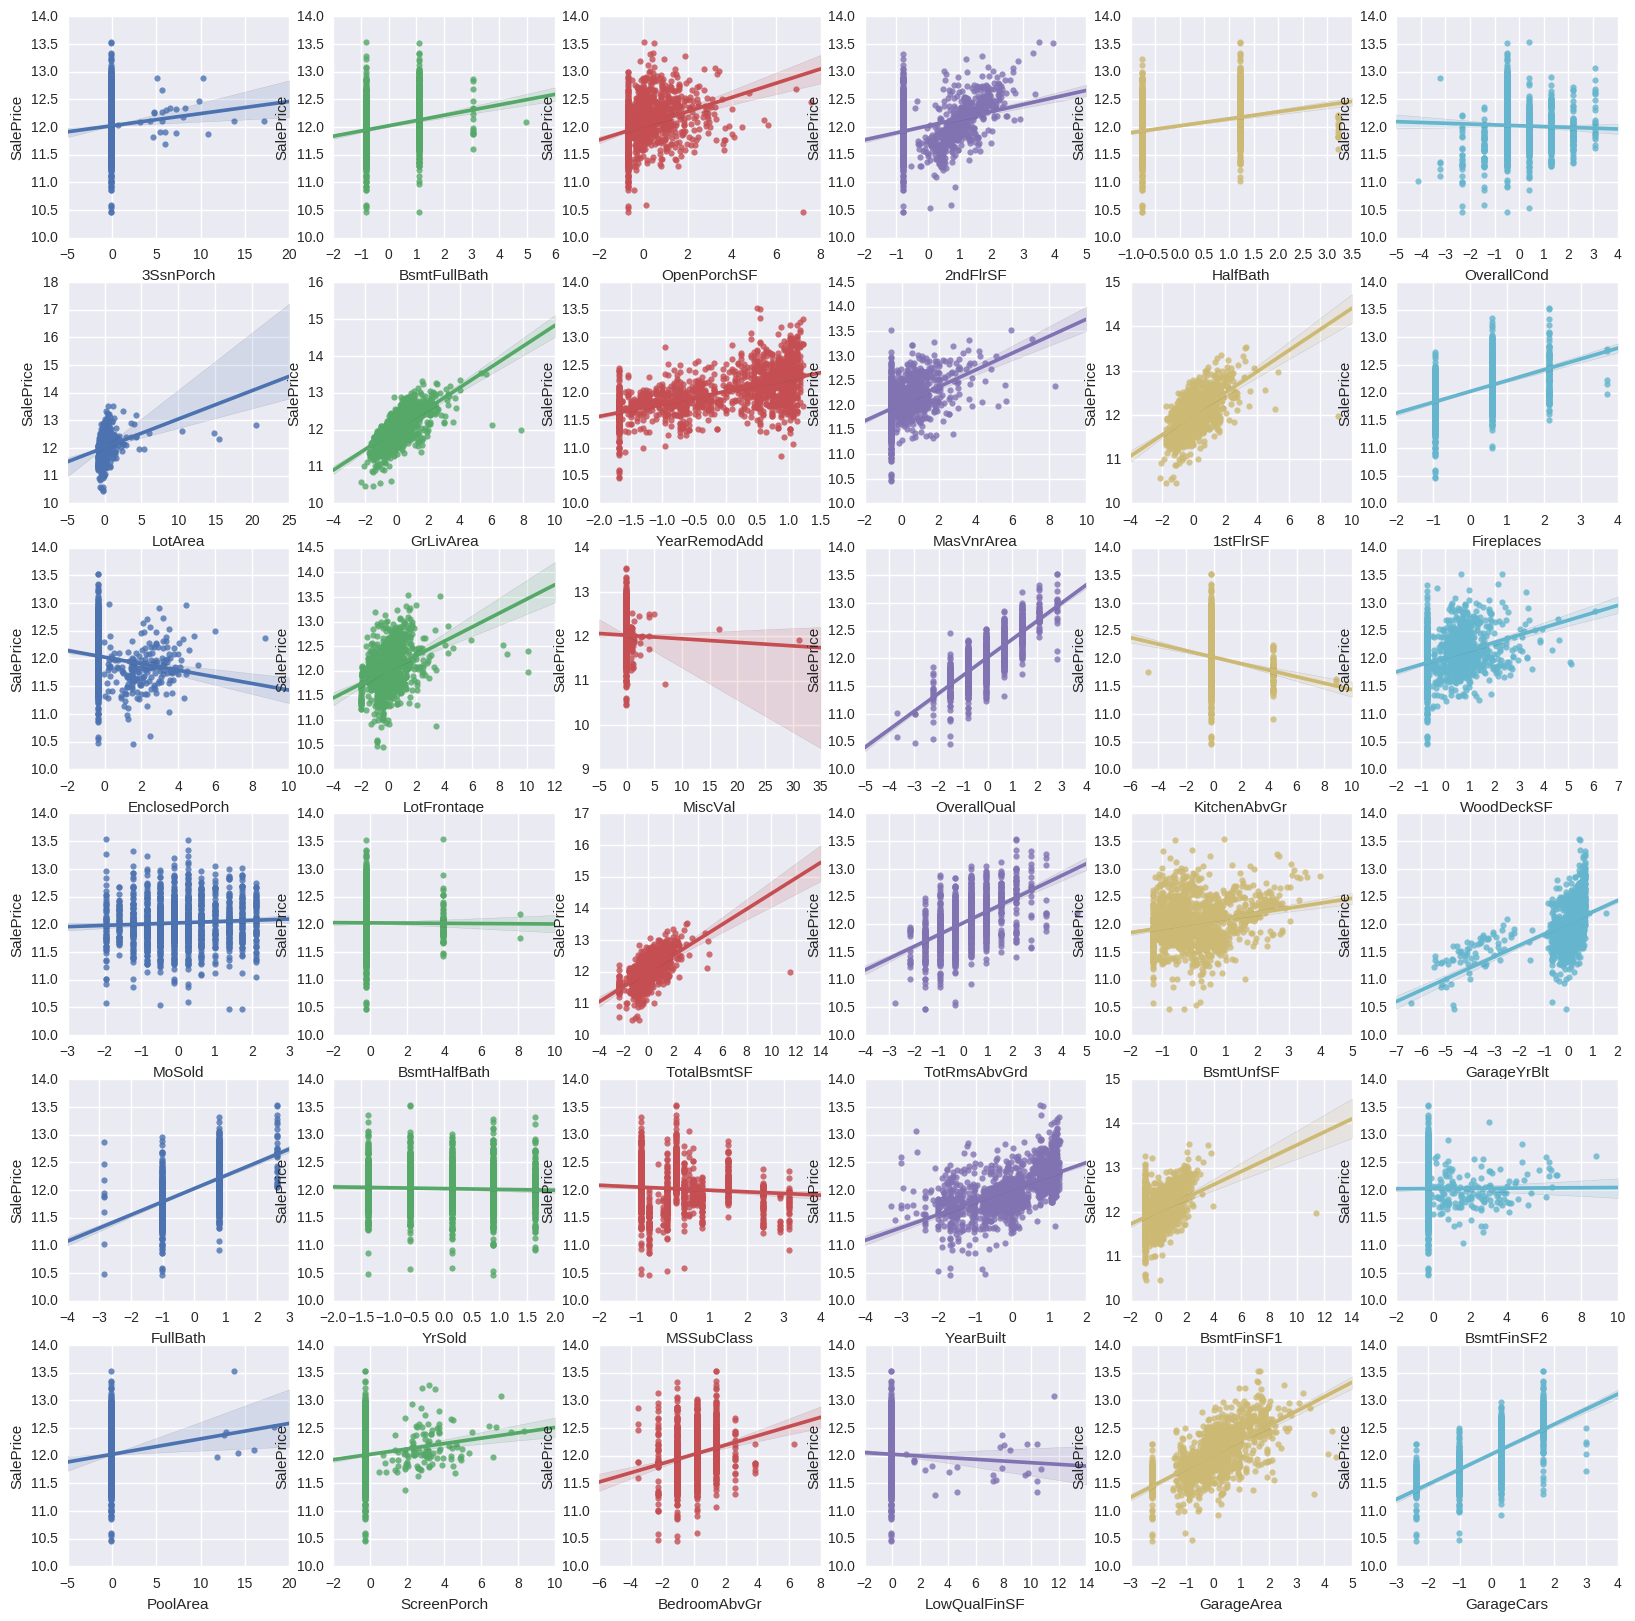

In [15]:
rcParams['figure.figsize'] = 20, 20
# take a look of each variable vs y
f, axes = plt.subplots(6,6)
n_iter = 0
for i in range(6):
    for j in range(6):
        sns.regplot(x=train_filled[num_columns[n_iter]], y=train_y,ax=axes[i][j])
        n_iter += 1

In [16]:
# from above we choose some features to discard
# features_discard = ['3SsnPorch', 'MiscVal', 'PoolArea', 'ScreenPorch', 'LowQualFinSF']
# discard
# train_filled.drop(features_discard, axis = 1, inplace=True)
# test_filled.drop(features_discard, axis = 1, inplace=True)

In [17]:
# ax = sns.pairplot(train_filled[std_features[:5]])

### train regression model

In [18]:
# def train_predict(train_X, train_Y, test_X, verbose=False):
#     n_cv = 200
#     prediction = []
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.1, random_state=42+n_i)
        
#         bst = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=3, 
#                                                  max_features='sqrt', min_samples_leaf=15, 
#                                                  min_samples_split=10, loss='huber',random_state=42+n_i)
#         bst.fit(x_train, y_train)
#         # make prediction
#         preds = bst.predict(x_val)
#         # convert prediction and validation label back to regular scale
#         preds = np.exp(preds)
#         y_val = np.exp(y_val)
#         r2 = metrics.r2_score(y_val, preds)
#         ms = metrics.mean_squared_error(y_val, preds)
#         print "r2:", r2
#         print "RMSLE:", np.sqrt(sum((np.log(np.array(preds)+1)-np.log(np.array(y_val)+1))**2)/len(preds))
#     #     xgb.plot_importance(bst)
#     #     xgb.plot_tree(bst,num_trees=10)

#         prediction_i = preds = bst.predict(test_X)
#         prediction.append(prediction_i)
    
#     print "Done training and predicting."
    
#     prediction = np.array(prediction)
# #     prediction = np.exp(np.array(prediction))
#     ensemble_result = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         # select predictions that are with 2 std from the mean
#         select_i = p_i[(np.abs(p_i-p_mean[i]) < 1.*p_std[i])]
#         ensemble_result.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble_result = np.exp(ensemble_result)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble_result})
#     result_df.to_csv('./result/result_gb50_knn_raw.csv', index=False)
    
# train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)

In [19]:
def train_predict(train_X, train_Y, test_X, verbose=False):
    t1 = time.time()
    param_grid = {'learning_rate':[0.1, 0.05, 0.02, 0.01],
                 'max_depth': [3,4,6],
                 'min_samples_leaf': [3,5,9,17],
                 'max_features': [0.1, 0.3, 1.0]}
    est = ensemble.GradientBoostingRegressor(loss='huber', n_estimators=8000)
    gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(train_X, train_Y)
    t2 = time.time()
    
    print "Total time used: {}min".format((t2-t1)/60.)
    print gs_cv.best_score_
    print gs_cv.best_params_
    pred = gs_cv.predict(test_X)
    
    result_df = pd.DataFrame({'Id': test_id, 'SalePrice':np.exp(pred)})
    result_df.to_csv('./result/gs_cv_gb2.csv', index=False)
    
train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)

Total time used: 17.3549730976min
0.908546113145
{'max_features': 0.1, 'learning_rate': 0.02, 'max_depth': 3, 'min_samples_leaf': 3}


In [20]:
# def train_predict(train_X, train_Y, test_X, verbose=False):
#     n_cv = 500
#     prediction = []
#     for n_i in range(n_cv):
#         if verbose:
#             print "[CV {}]".format(n_i)
#         x_train, x_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=42+n_i)
#         lm_i = linear_model.LinearRegression()
#         lm_i.fit(x_train, y_train)
#         acc_i = lm_i.score(x_val, y_val)
#         print acc_i
        
#         prediction_i = lm_i.predict(test_X)
#         prediction.append(prediction_i)
#     print "Done training and predicting."
    
#     prediction = np.array(prediction)
# #     prediction = np.exp(np.array(prediction))
#     ensemble = []
#     n, m = prediction.shape
#     p_std = np.std(prediction, axis=0) # along columns
#     p_mean = np.mean(prediction, axis=0)
#     for i in range(m):
#         p_i = prediction[:,i]
#         select_i = p_i[(np.abs(p_i-p_mean[i]) < 2.*p_std[i]) and (p_i>0.8)]
#         ensemble.append(np.mean(select_i))
#     # transform y back to normal scale
#     ensemble = np.exp(ensemble)
#     result_df = pd.DataFrame({'Id': test_id, 'SalePrice':ensemble})
#     result_df.to_csv('result.csv', index=False)
    
# train_predict(train_filled.values, train_y.values, test_filled.values, verbose=True)

In [21]:
time.time()

1490931615.471327